## Setup

In [1]:
import torch as th
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 3
from nnterp import load_model, collect_activations, patchscope_lens, TargetPrompt, collect_activations_batched

In [2]:
base_model = load_model("google/gemma-2-2b", device_map="cuda:0", dispatch=True)
it_model = load_model("google/gemma-2-2b-it", device_map="cuda:1", dispatch=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Diff in concept

In [3]:
def to_question(concept, it_tokenizer=None):
    q = f"What is the meaning of {concept}"
    if it_tokenizer is not None:
        q = it_tokenizer.apply_chat_template(
            [{"role": "user", "content": q}], continue_final_message=True, tokenize=False
        )
    return q

In [4]:
car_question = to_question("car")
dog_question = to_question("dog")
it_dog_question = to_question("dog", it_tokenizer=it_model.tokenizer, )
it_car_question = to_question("car", it_tokenizer=it_model.tokenizer, )

base_acts = collect_activations(base_model, [car_question, dog_question])
it_acts = collect_activations(it_model, [it_car_question, it_dog_question])
it_acts_no_template = collect_activations(it_model, [car_question, dog_question])

car_to_dog_base = base_acts[:, 0] - base_acts[:, 1]  # shape: (n_layers, h_dim)
car_to_dog_it = it_acts[:, 0] - it_acts[:, 1]
car_to_dog_it_no_template = it_acts_no_template[:, 0] - it_acts_no_template[:, 1]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [6]:
sun_question = to_question("sun")
table_question = to_question("table")
it_sun_question = to_question("sun", it_tokenizer=it_model.tokenizer)
it_table_question = to_question("table", it_tokenizer=it_model.tokenizer)

base_acts = collect_activations(base_model, [sun_question, table_question])
it_acts = collect_activations(it_model, [it_sun_question, it_table_question])
it_acts_no_template = collect_activations(it_model, [sun_question, table_question])

sun_to_table_base = base_acts[:, 0] - base_acts[:, 1]  # shape: (n_layers, h_dim)
sun_to_table_it = it_acts[:, 0] - it_acts[:, 1]
sun_to_table_it_no_template = it_acts_no_template[:, 0] - it_acts_no_template[:, 1]

### Check cosim among the 3 diffs

torch.Size([26])
torch.Size([26])
torch.Size([26])


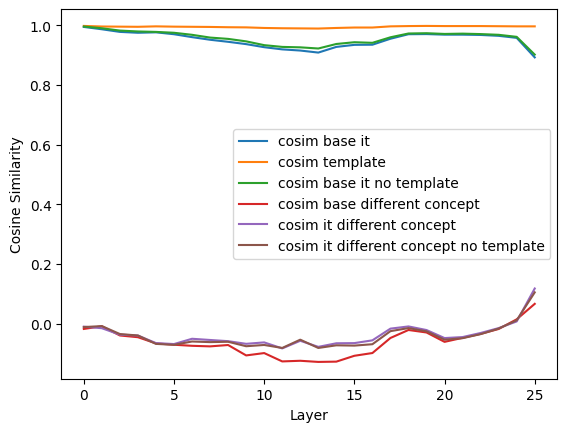

In [7]:
# plot mean cosim between the 3 diffs for each layer
cosim_base_it = th.nn.functional.cosine_similarity(car_to_dog_base, car_to_dog_it, dim=1)
cosim_template = th.nn.functional.cosine_similarity(car_to_dog_it, car_to_dog_it_no_template, dim=1)
cosim_base_it_no_template = th.nn.functional.cosine_similarity(car_to_dog_base, car_to_dog_it_no_template, dim=1)
cosim_base_diff = th.nn.functional.cosine_similarity(car_to_dog_base, sun_to_table_base, dim=1)
cosim_it_diff = th.nn.functional.cosine_similarity(car_to_dog_it, sun_to_table_it, dim=1)
cosim_it_diff_no_template = th.nn.functional.cosine_similarity(car_to_dog_it_no_template, sun_to_table_it_no_template, dim=1)
print(cosim_base_it.shape)
print(cosim_template.shape)
print(cosim_base_it_no_template.shape)
fig, ax = plt.subplots()
ax.plot(cosim_base_it, label="cosim base it")
ax.plot(cosim_template, label="cosim template")
ax.plot(cosim_base_it_no_template, label="cosim base it no template")
ax.plot(cosim_base_diff, label="cosim base different concept")
ax.plot(cosim_it_diff, label="cosim it different concept")
ax.plot(cosim_it_diff_no_template, label="cosim it different concept no template")
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.legend()
plt.show()


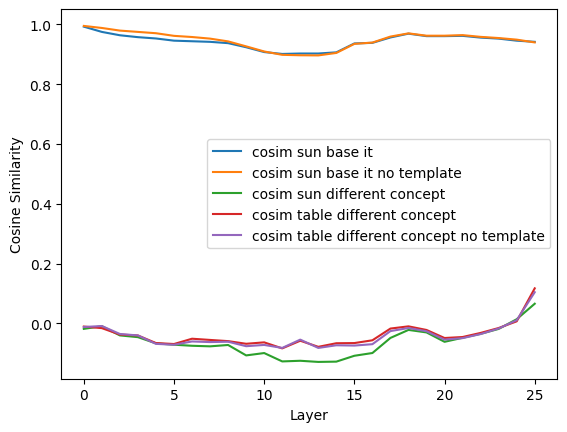

In [8]:
# check sun - table cosim
cosim_sun_base_it = th.nn.functional.cosine_similarity(sun_to_table_base, sun_to_table_it, dim=1)
cosim_sun_base_it_no_template = th.nn.functional.cosine_similarity(sun_to_table_base, sun_to_table_it_no_template, dim=1)
cosim_sun_diff = th.nn.functional.cosine_similarity(sun_to_table_base, car_to_dog_base, dim=1)
cosim_table_diff = th.nn.functional.cosine_similarity(sun_to_table_it, car_to_dog_it, dim=1)
cosim_table_diff_no_template = th.nn.functional.cosine_similarity(sun_to_table_it_no_template, car_to_dog_it_no_template, dim=1)
fig, ax = plt.subplots()
ax.plot(cosim_sun_base_it, label="cosim sun base it")
ax.plot(cosim_sun_base_it_no_template, label="cosim sun base it no template")
ax.plot(cosim_sun_diff, label="cosim sun different concept")
ax.plot(cosim_table_diff, label="cosim table different concept")
ax.plot(cosim_table_diff_no_template, label="cosim table different concept no template")
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.legend()
plt.show()


## Unembedding/Embedding matrix stuff

In [3]:
base_model.lm_head.weight.shape, it_model.lm_head.weight.shape

(torch.Size([256000, 2304]), torch.Size([256000, 2304]))

In [8]:
# compute cosim between both lm_heads vectors
cosim_lm_heads = th.nn.functional.cosine_similarity(base_model.lm_head.weight.data.cpu().float(), it_model.lm_head.weight.data.cpu().float(), dim=1)
# bar plot using plotly
# import plotly.express as px
# fig = px.bar(x=range(len(cosim_lm_heads)), y=cosim_lm_heads, labels={"x": "Layer", "y": "Cosine Similarity"}, title="Cosine Similarity between LM Heads")
# fig.show()

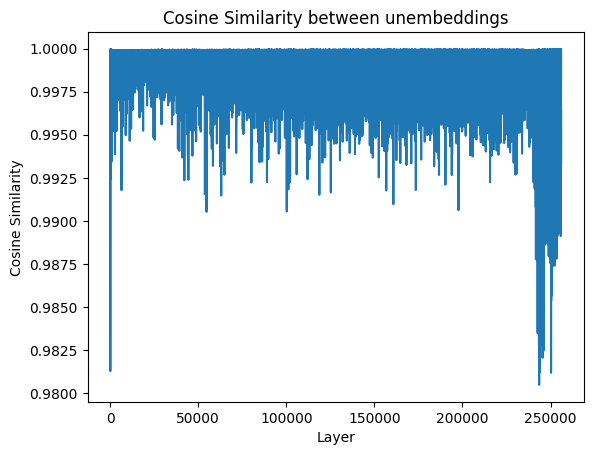

In [10]:
# normal plot using matplotlib
fig, ax = plt.subplots()
# ax.bar(range(len(cosim_lm_heads)), cosim_lm_heads)
ax.plot(cosim_lm_heads)
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Cosine Similarity between unembeddings")
plt.show()


In [35]:
base_model.tokenizer.convert_tokens_to_ids("<end_of_turn>")

107

In [32]:
# Print the tokens with cosim < 0.99
token_and_cosim = []
for i, c in enumerate(cosim_lm_heads):
    if c < 0.99:
        c = th.round(c, decimals=3).item()
        token = base_model.tokenizer.decode(i)
        assert token == it_model.tokenizer.decode(i)
        token_and_cosim.append((i, token, c))
token_and_cosim.sort(key=lambda x: x[2], reverse=False)
for i, token, c in token_and_cosim:    
    print(f"id: {i}, token: {token}, cosim: {c:.3f}")


id: 243537, token: ﾏ, cosim: 0.980
id: 69, token: <unused62>, cosim: 0.981
id: 243862, token: ｵ, cosim: 0.981
id: 250298, token: 𝙻, cosim: 0.981
id: 243503, token: ﾋ, cosim: 0.982
id: 245499, token: ﾓ, cosim: 0.982
id: 246077, token: ｿ, cosim: 0.982
id: 242672, token: ｷ, cosim: 0.983
id: 243435, token: ﾎ, cosim: 0.983
id: 243939, token: ｻ, cosim: 0.983
id: 245232, token: ｾ, cosim: 0.983
id: 68, token: <unused61>, cosim: 0.984
id: 243777, token: ﾚ, cosim: 0.984
id: 244364, token: ﾅ, cosim: 0.985
id: 245095, token: ｹ, cosim: 0.985
id: 250340, token: 𝙲, cosim: 0.985
id: 243095, token: ﾃ, cosim: 0.986
id: 244303, token: ﾆ, cosim: 0.986
id: 250823, token: 𝙿, cosim: 0.986
id: 70, token: <unused63>, cosim: 0.987
id: 244168, token: ﾜ, cosim: 0.987
id: 250421, token: 𝙳, cosim: 0.987
id: 251490, token: 𝙱, cosim: 0.987
id: 252467, token: 𝙵, cosim: 0.987
id: 67, token: <unused60>, cosim: 0.988
id: 241697, token: ﾌ, cosim: 0.988
id: 242819, token: ﾗ, cosim: 0.988
id: 245306, token: ﾂ, cosim: 0.988


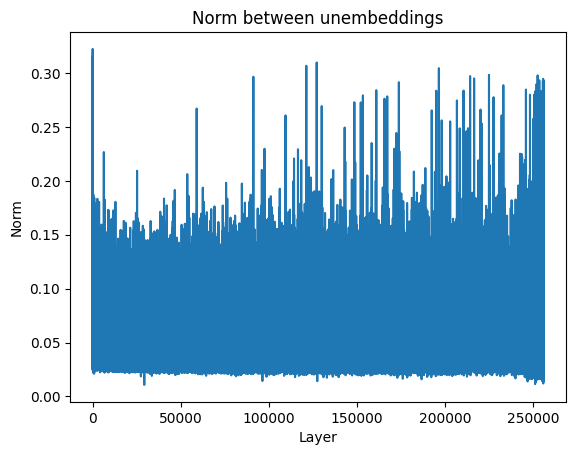

In [11]:
norm_between_unembeddings = th.norm(base_model.lm_head.weight.data.cpu().float() - it_model.lm_head.weight.data.cpu().float(), dim=1)
fig, ax = plt.subplots()
ax.plot(norm_between_unembeddings)
ax.set_xlabel("Layer")
ax.set_ylabel("Norm")
ax.set_title("Norm between unembeddings")
plt.show()



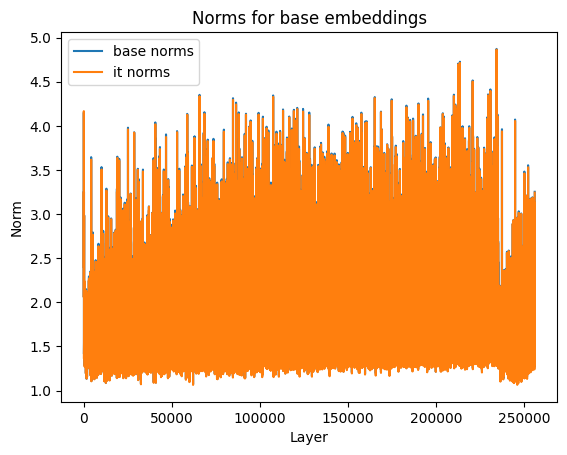

In [14]:
# plot norms for base embeddings
base_norms = th.norm(base_model.lm_head.weight.data.cpu().float(), dim=1)
it_norms = th.norm(it_model.lm_head.weight.data.cpu().float(), dim=1)
fig, ax = plt.subplots()
ax.plot(base_norms, label="base norms")
ax.plot(it_norms, label="it norms")
ax.set_xlabel("Layer")
ax.set_ylabel("Norm")
ax.set_title("Norms for base embeddings")
ax.legend()
plt.show()

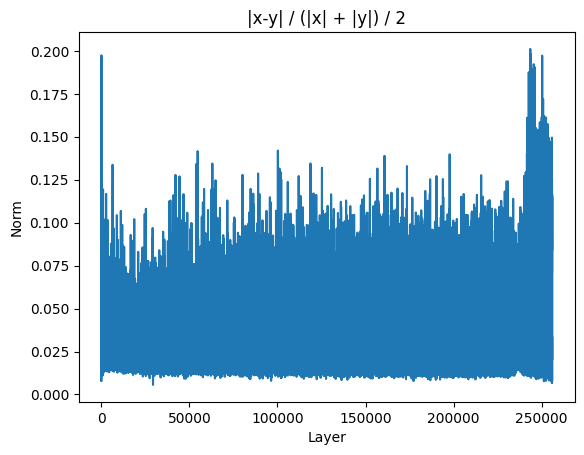

In [20]:
# plot the percentage of diff regarding mean of both norms
diff_norms = norm_between_unembeddings / ((base_norms + it_norms) / 2)
fig, ax = plt.subplots()
ax.plot(diff_norms)
ax.set_xlabel("Layer")
ax.set_ylabel("Norm")
ax.set_title("|x-y| / (|x| + |y|) / 2")
plt.show()



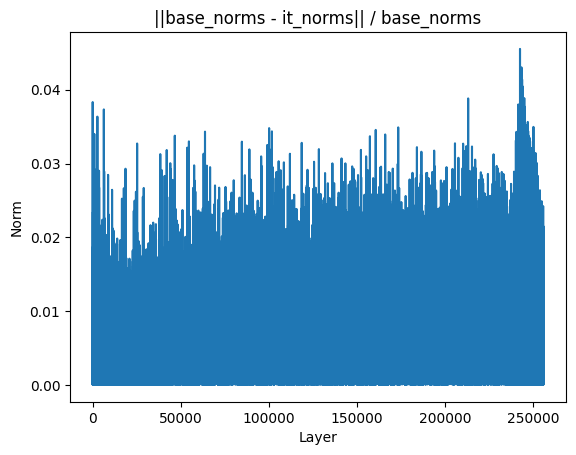

In [55]:
# plot the percentage of diff regarding mean of both norms
fig, ax = plt.subplots()
ax.set_xlabel("Layer")
ax.set_ylabel("Norm")
ax.set_title("||base_norms - it_norms|| / base_norms")
normalized_diff_norms = (base_norms - it_norms).abs() / base_norms
ax.plot(normalized_diff_norms)
plt.show()

In [41]:
print(cosim_lm_heads[base_model.tokenizer.convert_tokens_to_ids("<end_of_turn>")], cosim_lm_heads[base_model.tokenizer.convert_tokens_to_ids("<start_of_turn>")])
print(diff_norms[base_model.tokenizer.convert_tokens_to_ids("<end_of_turn>")], diff_norms[base_model.tokenizer.convert_tokens_to_ids("<start_of_turn>")])
print(normalized_diff_norms[base_model.tokenizer.convert_tokens_to_ids("<end_of_turn>")], normalized_diff_norms[base_model.tokenizer.convert_tokens_to_ids("<start_of_turn>")])

tensor(0.9977) tensor(0.9996)
tensor(0.0682) tensor(0.0279)
tensor(0.0022) tensor(0.0003)


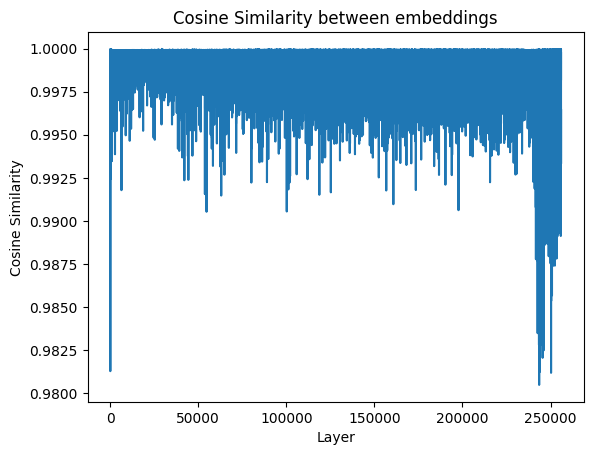

torch.Size([256000, 2304])


In [48]:
## Let's do the same for the embedding matrix
base_embeddings = base_model.model.embed_tokens.weight.data.cpu().float()
it_embeddings = it_model.model.embed_tokens.weight.data.cpu().float()
cosim_embeddings = th.nn.functional.cosine_similarity(base_embeddings, it_embeddings, dim=1)
fig, ax = plt.subplots()
ax.plot(cosim_embeddings)
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Cosine Similarity between embeddings")
plt.show()
print(base_embeddings.shape)

## Special tokens diffs

In [4]:
empty_chat = [
    {"role": "user", "content": ""}
]
empty_chat = it_model.tokenizer.apply_chat_template(empty_chat, tokenize=False)
print(empty_chat)
beginning = "<bos><start_of_turn>"


<bos><start_of_turn>user
<end_of_turn>



In [5]:
base_acts = collect_activations(base_model, [beginning, empty_chat])
it_acts = collect_activations(it_model, [beginning, empty_chat])
print(base_acts.shape)

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([26, 2, 2304])


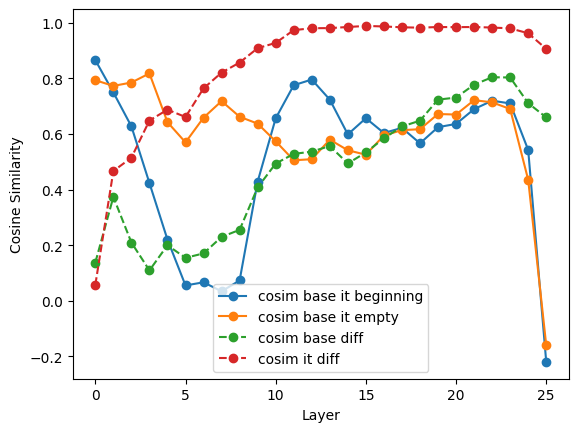

In [6]:
cosim_base_it_beginning = th.nn.functional.cosine_similarity(base_acts[:, 0], it_acts[:, 0], dim=1)
cosim_base_it_empty = th.nn.functional.cosine_similarity(base_acts[:, 1], it_acts[:, 1], dim=1)
cosim_base_diff = th.nn.functional.cosine_similarity(base_acts[:, 0], base_acts[:, 1], dim=1)
cosim_it_diff = th.nn.functional.cosine_similarity(it_acts[:, 0], it_acts[:, 1], dim=1)
fig, ax = plt.subplots()
ax.plot(cosim_base_it_beginning, label="cosim base it beginning", marker="o")
ax.plot(cosim_base_it_empty, label="cosim base it empty", marker="o")
ax.plot(cosim_base_diff, label="cosim base diff", marker="o", linestyle="--")
ax.plot(cosim_it_diff, label="cosim it diff", marker="o", linestyle="--")
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.legend()
plt.show()


In [64]:
print(f'beginning: "{beginning}"')
print(f'empty: "{empty_chat}"')

beginning: "<bos><start_of_turn>"
empty: "<bos><start_of_turn>user
<end_of_turn>
"


In [7]:
from nnterp.display import plot_topk_tokens
from nnterp.nnsight_utils import next_token_probs
probs = next_token_probs(it_model, [beginning, empty_chat])
probs.shape

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


torch.Size([2, 256000])

In [20]:
fig = plot_topk_tokens(probs, it_model.tokenizer, k=5)

In [18]:
from pathlib import Path
Path("test.html").suffix

'.html'